# Training on MNIST Dataset

In [ ]:
import numpy as np
import jax
from jax.scipy.special import logsumexp
import jax.numpy as jnp
from jax import jit,pmap,vmap,grad,value_and_grad
from torchvision.datasets import MNIST
from torchvision import transforms, utils, datasets, models
from torch.utils.data import DataLoader,random_split
import torch

In [ ]:
mnist_img_size=(28,28)
seed=0
def init_MLP(layer_widths,parent_key,scale=0.01):
    params=[]
    keys=jax.random.split(parent_key,num=len(layer_widths)-1)
    for in_width,out_width,key in zip(layer_widths[:-1],layer_widths[1:],keys):
        weight_key,bias_key = jax.random.split(key)
        params.append(
        [scale*jax.random.normal(weight_key,shape=(out_width,in_width)),scale*jax.random.normal(bias_key,shape=(out_width,))])
        
    return params
key=jax.random.PRNGKey(seed)
MLP_params = init_MLP([784,512,256,10],key)
print(jax.tree_map(lambda x:x.shape,MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [ ]:
print(np.prod(mnist_img_size))

784


In [ ]:
def MLP_predict(params,x):
  hidden_layers=params[:-1]

  activation=x
  for w,b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w,activation)+b)
  w_last,b_last=params[-1]
  logits=jnp.dot(w_last,activation)+b_last
  return logits - logsumexp(logits)

# Testing a single example
dummy_img_flat=np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction=MLP_predict(MLP_params,dummy_img_flat)
print(prediction.shape)

#Testing Batch of examples
batched_MLP_predict= vmap(MLP_predict,in_axes=(None,0))

dummy_img_flat=np.random.randn(16,np.prod(mnist_img_size))
print(dummy_img_flat.shape)
predictions=batched_MLP_predict(MLP_params,dummy_img_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


#Adding data loading in PyTorch


In [ ]:
from numpy.core.fromnumeric import transpose
def custom_transform(x):
  y=np.ravel(np.array(x,dtype=np.float32))
  return y

def custom_collate_fn(batch):
   transposed_data=list(zip(*batch))
   
   labels=np.array(transposed_data[1])
   imgs=np.array(transposed_data[0])
 
   return imgs,labels
batch_size= 128
train_dataset= MNIST(root='train_mnist',train=True,download=True,transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

print(len(train_dataset))
print(len(test_dataset))

img=train_dataset[0][0]
print(img.shape)

train_Loader= DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn,drop_last=True)
test_Loader= DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn,drop_last=True)

#Testing 
batch_data=next(iter(train_Loader))
imgs=batch_data[0]
lbls=batch_data[1]
print(imgs.shape,imgs[0].dtype,lbls.shape,lbls[0].dtype)

#Optimization- Loading the full dataset in memory
train_images=jnp.array(train_dataset.data).reshape(len(train_dataset),-1)
train_lbls=jnp.array(train_dataset.targets)

test_images=jnp.array(test_dataset.data).reshape(len(test_dataset),-1)
test_lbls=jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

60000
10000
(784,)
(128, 784) float32 (128,) int64


In [ ]:
num_epochs=10
def loss_fn(params,imgs,gt_lbls):
  predictions = batched_MLP_predict(params,imgs)

  return -jnp.mean(predictions*gt_lbls)
def update(params,imgs,gt_lbls,lr=0.02):
  loss, grads=value_and_grad(loss_fn)(params,imgs,gt_lbls)

  return loss,jax.tree_multimap(lambda p,g:p-lr*g,params,grads)
def accuracy(params,dataset_imgs,dataset_lbls):
      pred_classes = jnp.argmax(batched_MLP_predict(params,dataset_imgs),axis=1)
      return np.mean(dataset_lbls==pred_classes)
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_Loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.23406783
0.104191065
0.054205775
0.047208447
0.047257494
0.029524868
0.037343055
0.03850145
0.026495824
0.024601731
Epoch 0, train acc = 0.9150833487510681 test acc = 0.9170999526977539
0.020816023
0.028814772
0.029622985
0.01759463
0.021385282
0.030298352
0.030682582
0.030753607
0.026010651
0.01432459
Epoch 1, train acc = 0.933650016784668 test acc = 0.9332000017166138
0.02483926
0.016409649
0.020527108
0.020295022
0.025697261
0.02189367
0.024743743
0.021260595
0.016048126
0.020890942
Epoch 2, train acc = 0.9472500085830688 test acc = 0.9429999589920044
0.01683336
0.018177923
0.017524553
0.029659733
0.01637794
0.01631601
0.025035147
0.016522959
0.018792318
0.009200659
Epoch 3, train acc = 0.9527000188827515 test acc = 0.9480999708175659
0.025549153
0.011754341
0.015587767
0.02153588
0.023932818
0.010032161
0.020414593
0.02396035
0.008948119
0.016711459
Epoch 4, train acc = 0.9615166783332825 test acc = 0.9558999538421631
0.0128926635
0.013523752
0.009117226
0.011546931
0.021980489
0

(28, 28)
pred 2
gt 2


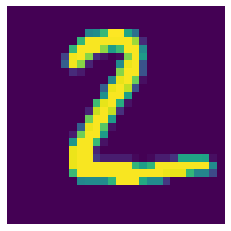

In [ ]:
imgs, lbls = next(iter(test_Loader))
img = imgs[1].reshape(mnist_img_size)
gt_lbl = lbls[1]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)
plt.axis("off")
plt.imshow(img); plt.show()

# Dataset Visualization

(512, 784)
(28, 28)


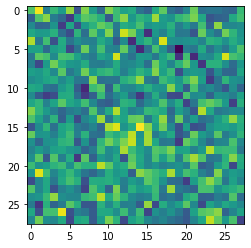

In [ ]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[300, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

(128, 256)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyError: ignored

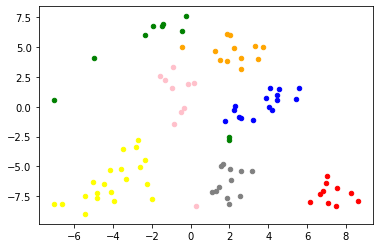

In [ ]:
# Visualize embeddings using t-SNE

from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
imgs, lbls = next(iter(test_Loader))

batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 2)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()

In [ ]:
# Dead neurons

def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        collector.append(activation)

    return collector

batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))

imgs, lbls = next(iter(test_Loader))

MLP_params2 = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape)  # (128, 512/256)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layer_id, activations in enumerate(batch_activations):
    dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))


(128, 256)
0
7
